#### "Good Copy" version of the code to generate plots of $C_{\ell}(\nu \nu')$

In [3]:
import healpy as hp
import numpy as np
import os
import astropy.units as u
import matplotlib.pyplot as plt
from pygdsm import GlobalSkyModel16
%matplotlib inline

For visualizing the GSM emission maps

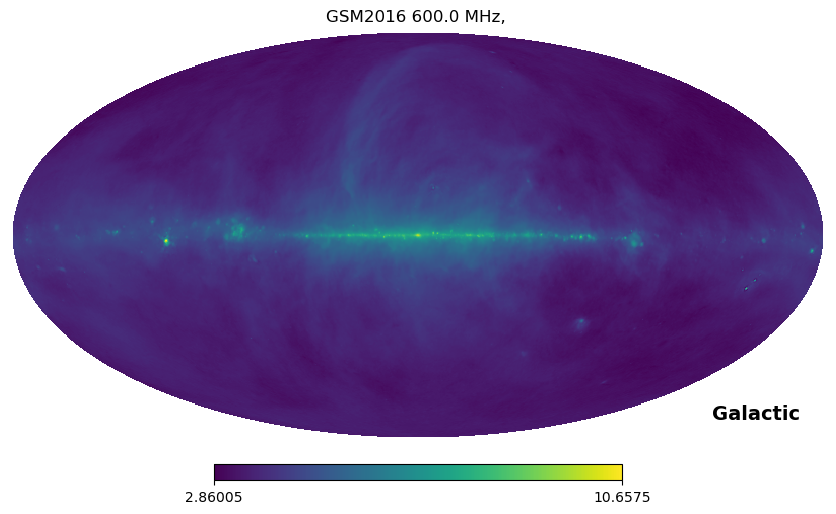

In [4]:
gsm = GlobalSkyModel16(freq_unit='MHz', resolution='hi')
gsm.generate(600) #generate the map at 500 MHz
gsm.view(logged=True)

Note that gsm files are already stored as Numpy arrays

In [5]:
sm = gsm.generate(200)
print(sm.shape)
print(type(sm))

(12582912,)
<class 'numpy.ndarray'>


In [6]:
nside = 1024 #default nside from GSM generate
lmax = 2*nside
C_l = hp.anafast(sm, lmax=lmax)


Plot the $C_{\ell}(\nu \nu')s $

Essentially, just use healpy (anafast) to generate the power spectrum from the all sky maps and plot the power spectrum (ie. the C_ls)

Text(0, 0.5, '$C_\\ell$ [K$^2$]')

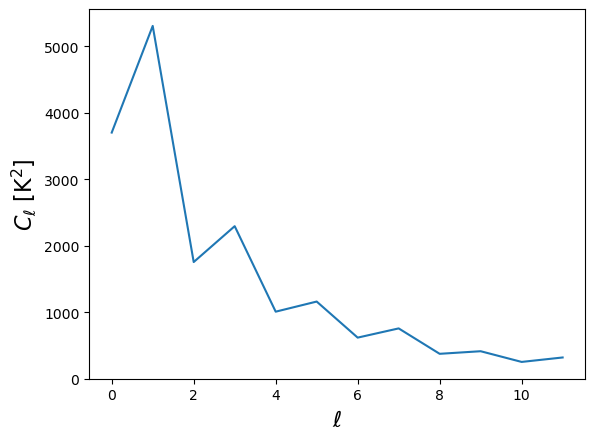

In [7]:
plt.plot(C_l[3:15])
plt.xlabel(r"$\ell$", fontsize=16)
plt.ylabel(r'$C_\ell$ [K$^2$]', fontsize=16)


### Conversely...

Just for the sake of it, we can do the above in two steps also using healpy using map2alm (calcs each alm - for each l and m) and use this to calc the cls (ie using alm2cl).

Number of coefficients: 33153
Example coefficient a_{10,0} = -2.149e+02+0.000e+00j


/tmp/ipykernel_28211/1151357.py:31: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  recon = hp.alm2map(alm, nside=nside, lmax=lmax, verbose=False)


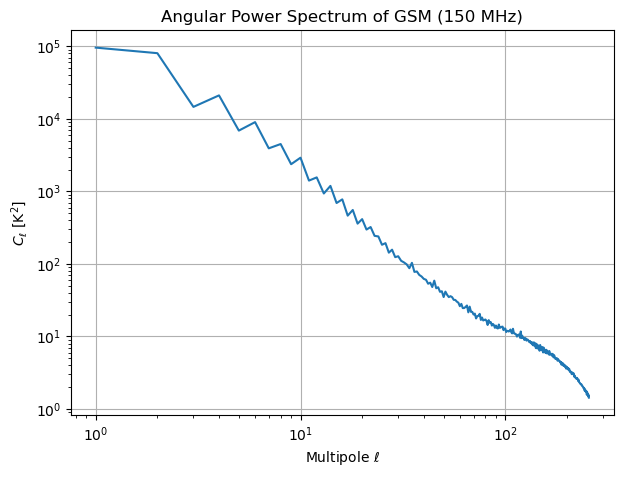

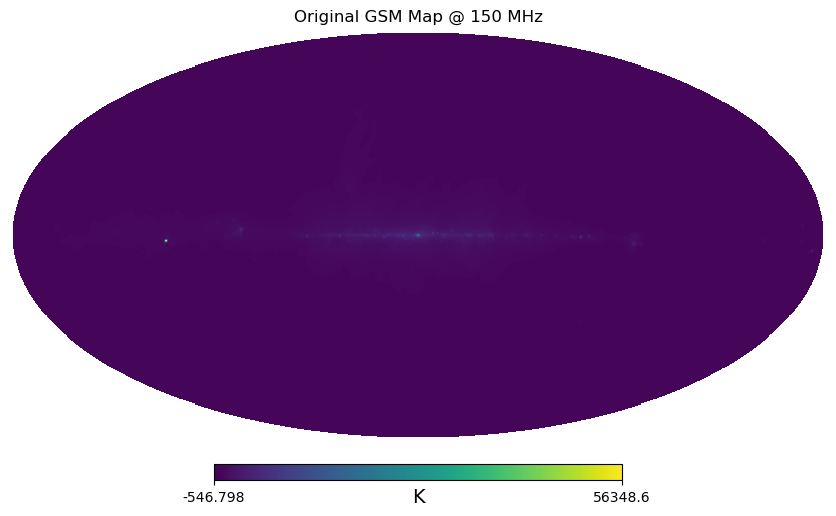

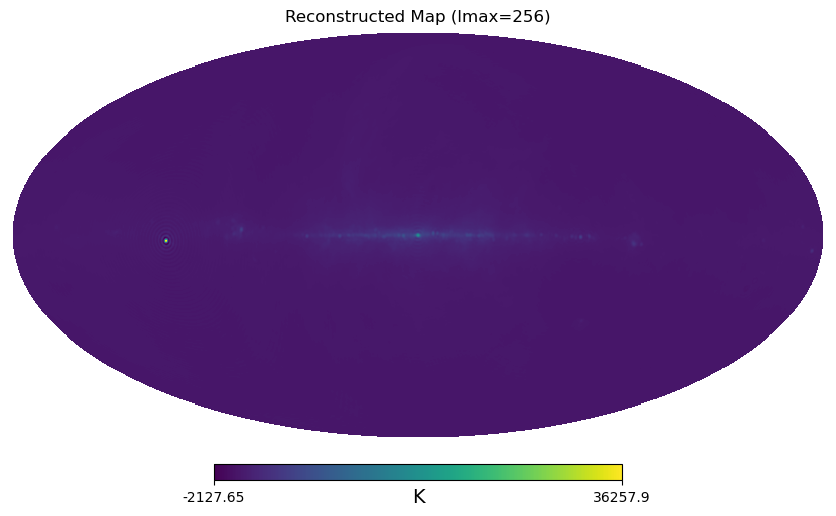

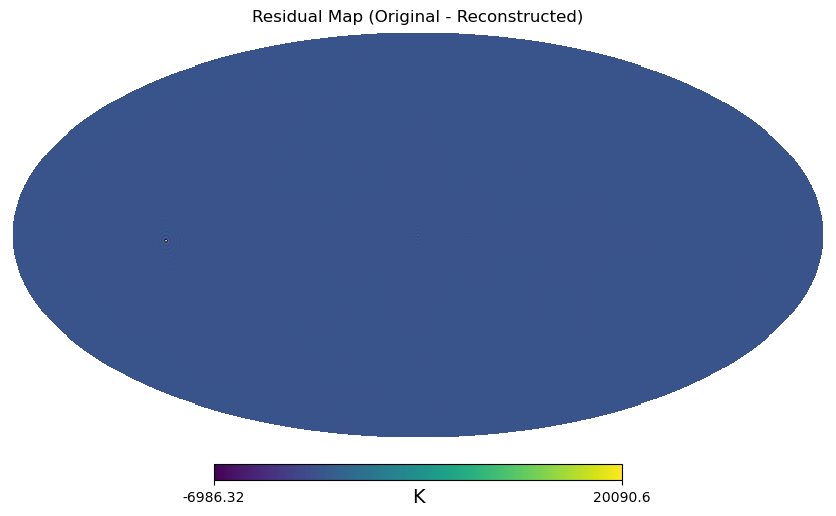

In [8]:
# ----------------------------
# 1. Generate a sky map (in Kelvin)
# ----------------------------
gsm = GlobalSkyModel16()
freq = 150  # MHz
sky = gsm.generate(freq)  # shape = (N_pix,)

nside = hp.get_nside(sky)
lmax = 256  # maximum multipole for harmonic decomposition

# ----------------------------
# 2. Compute spherical harmonic coefficients a_{ℓm}
# ----------------------------
alm = hp.map2alm(sky, lmax=lmax)

print(f"Number of coefficients: {alm.size}")
print(f"Example coefficient a_{{10,0}} = {alm[hp.Alm.getidx(lmax, 10, 0)]:.3e}")

# ----------------------------
# 3. Compute the angular power spectrum C_ℓ = <|a_{ℓm}|²>
# ----------------------------
cl = hp.alm2cl(alm)

# Convert multipole ℓ to approximate angular scale in degrees
ell = np.arange(len(cl))
theta_deg = 180.0 / (ell + 0.5)

# ----------------------------
# 4. Reconstruct the map from a_{ℓm}
# ----------------------------
recon = hp.alm2map(alm, nside=nside, lmax=lmax, verbose=False)

# ----------------------------
# 5. Plot the results
# ----------------------------

plt.figure(figsize=(7,5))
plt.loglog(ell[1:], cl[1:])
plt.xlabel(r'Multipole $\ell$')
plt.ylabel(r'$C_\ell$ [K$^2$]')
plt.title('Angular Power Spectrum of GSM (150 MHz)')
plt.grid(True)
plt.show()

# Original vs reconstructed map
hp.mollview(sky, title=f'Original GSM Map @ {freq} MHz', unit='K')
hp.mollview(recon, title=f'Reconstructed Map (lmax={lmax})', unit='K')
hp.mollview(sky - recon, title='Residual Map (Original - Reconstructed)', unit='K')


### GSM Covariance Matrix

The goal is to compute the covariance object as a result of comparing the spherical harmonic composition coefficients at different frequencies - ie calculating the covariance of harmonic coefficients at different $\nu$s.

In [9]:
#start by providing a list of frequencies over which to compute the covariance
freqs = np.linspace(400, 1400, 20)
nside = 1024  #default gsm nside

gsm = GlobalSkyModel16()    #create the GSM object

#compile the sky maps at each frequency
sky_maps = []
for f in freqs:
    sky_map = gsm.generate(f)
    sky_maps.append(sky_map)

sky_maps = np.array(sky_maps)
print("Shape of the sky maps array is:", sky_maps.shape)

Shape of the sky maps array is: (20, 12582912)


#### Compute the power spectrum - $C_{\ell}(\nu \nu')$ 

There are two ways to do this. One is to just use anafast and compute the Cls directly. Whereas the second is to do this in 2 steps using map2alm and alm2cl. ***I believe...*** that anafast is the slower approach since it calculates the Cls on the whole sphere or something like this..

In [10]:
lmax = 3*nside - 1
alm_list = []

for i in range(len(freqs)):
    alm = hp.map2alm(sky_maps[i], lmax = lmax)
    alm_list.append(alm)

alm_list = np.array(alm_list)
print('alm_list shape', alm_list.shape)

alm_list shape (20, 4720128)


#### Compute the covariance matrix

In [14]:
#initialize a covariance matrix with the 3rd axis having dimensions of the number of l modes
cl_cov_mat = np.zeros((len(freqs), len(freqs), lmax+1))

for i in range(len(freqs)):
    for j in range(len(freqs)):
        cl_cov_mat[i, j, :] = hp.alm2cl(alm_list[i], alm_list[j])

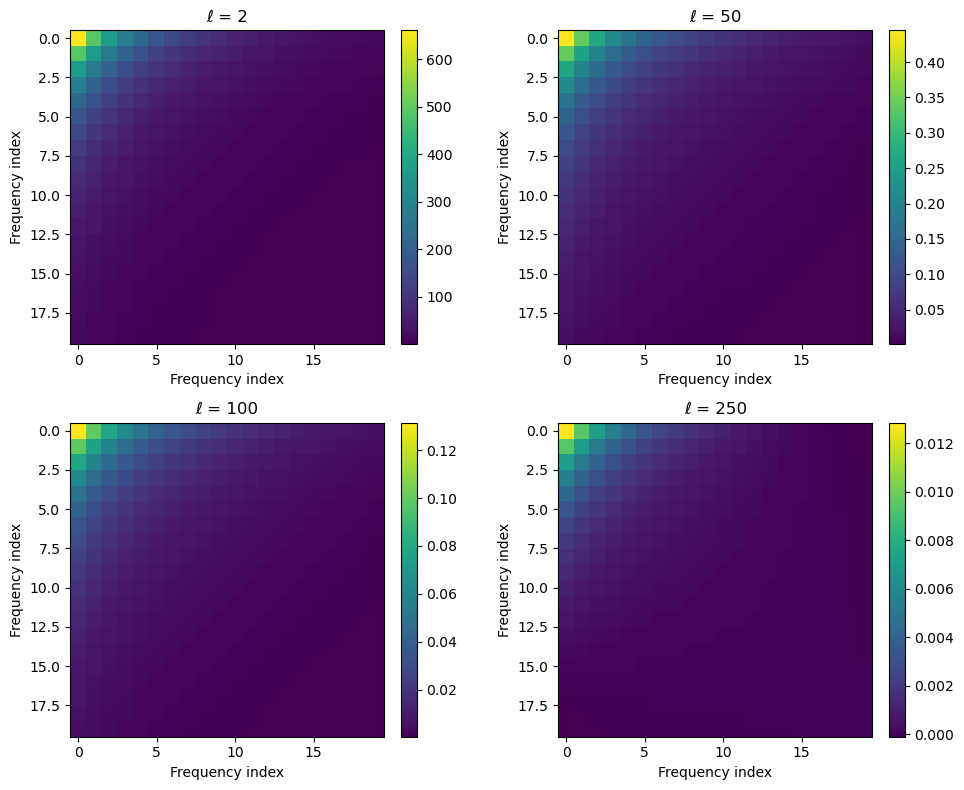

In [22]:
#plot the covariance for various values of l modes
l_modes = np.array([2, 50, 100, 250])


fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

for i, l in enumerate(l_modes):
    im = axes[i].imshow(cl_cov_mat[:,:,l], origin='upper', cmap='viridis')
    axes[i].set_title(f'ℓ = {l}')
    axes[i].set_xlabel('Frequency index')
    axes[i].set_ylabel('Frequency index')
    fig.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

# Adjust layout
plt.tight_layout()
plt.show()

A couple of comments are in order. First of all, the behaviour seems strange at first since there is no 'main diagonal' and the off diagonals are all equal valued. The result is due to a general power law 

$$T(\hat{\textbf{r}}, \nu_*) = T(\hat{\textbf{r}}, \nu_*) \left ( \frac{\nu}{\nu_*} \right) ^{\beta}$$

that is applied to each map as a result of synchrotron radiation which is relativistic radiation that is accelerated along magnetic fields. Although it can vary, $\beta$ is typically taken to be $\sim$ 2.5 for synchrotron radiation. Although after talking to Jon today, he was saying things may be between 0.7 - 0.8 so idk. I have to check this.



We can observe this power law by examining the diagonal of one of the plots above:

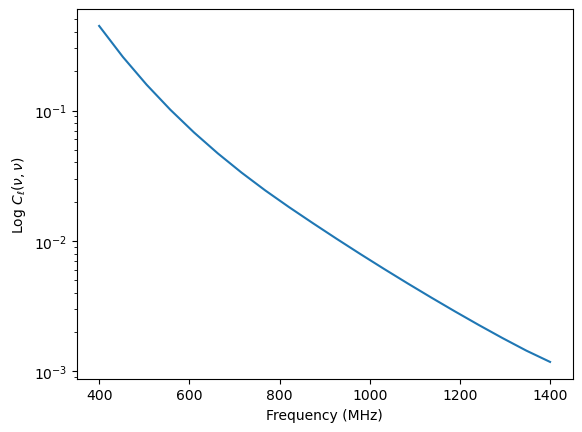

In [62]:
plt.semilogy(freqs, np.diag(cl_cov_mat[:,:,50]))
plt.xlabel("Frequency (MHz)")
plt.ylabel(r"Log $C_{\ell} (\nu, \nu)$")
plt.show()

We can also double check to see which $\ell$-modes are useful by plotting along the $\ell$ axis for fixed frequencies.

In [39]:
print(freqs[0])
print(freqs[int(len(freqs)/2)])
print(freqs[-1])

400.0
926.3157894736842
1400.0


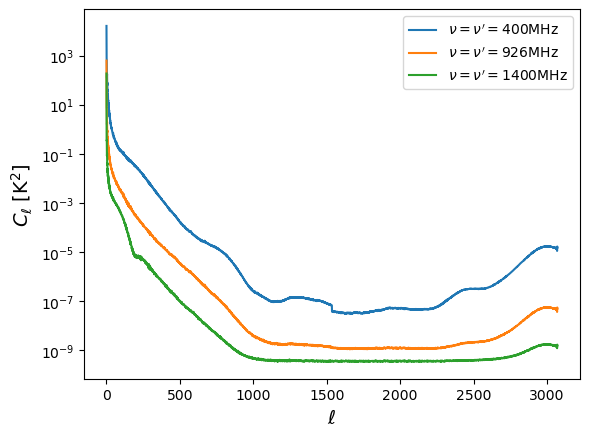

In [42]:
plt.semilogy(cl_cov_mat[0,0,:], label = r"$\nu =\nu'=$400MHz")
plt.semilogy(cl_cov_mat[int((cl_cov_mat.shape[0])/2)
                        ,int((cl_cov_mat.shape[0])/2),:]
                        , label = r"$\nu =\nu'=$926MHz")
plt.semilogy(cl_cov_mat[-1,-1,:], label = r"$\nu =\nu'=$1400MHz")
plt.xlabel(r"$\ell$", fontsize=14)
plt.ylabel(r'$C_\ell$ [K$^2$]', fontsize=14)
plt.legend()
plt.show()

Apparently there is a significance to the value of $C_{\ell}$ at close to $10^{-5}$ for the science we are doing that indicates that the $\ell$-modes beyond this value are insignificant. Therefore the cutoff is close to $\ell$=250 before we don't need to care about modes beyond that.

We can now compute the correlation coefficient for each $\ell$-mode:

$$C_{corr-coeff} = \frac{\sqrt{C_{\ell} (\nu, \nu')}}{\sqrt{C_{\ell} (\nu)}\sqrt{C_{\ell} (\nu')}}$$

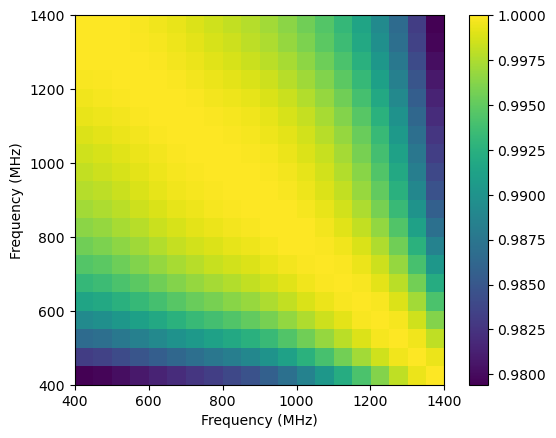

In [55]:
#choose an ell to plot (in practice the full covariance sums over l-modes)
my_l = 5

#initialize covariance matrix
tmp = 0*cl_cov_mat[:, :, my_l]

#populate correlation matrix
for i in range(len(freqs)):
    for j in range(len(freqs)):
        tmp[i, j] = cl_cov_mat[i, j, my_l]/np.sqrt(cl_cov_mat[i, i, my_l]*cl_cov_mat[j, j, my_l])

im = plt.imshow(tmp, origin='upper', extent=[freqs[0], freqs[-1], freqs[0], freqs[-1]])
plt.xlabel("Frequency (MHz)")
plt.ylabel("Frequency (MHz)")
plt.colorbar(im)
plt.show()

#### Eigenvalue Information

To check whether we can represent the above covariance with a fewer set of numbers, we take the eigendecomp and see how many modes are above the desired threshold (Jon was using 10^{-6} - I think $\to$ I still need to understand why..). Ahh it could just be in terms of the greatest one. 

In other words, the threshold is something like for an eigenvalue $v_i$, we want to know the number of modes such that $\frac{v_i}{max(\textbf{v})} > 10^{-6}$.

In [57]:
e_val, e_vec = np.linalg.eigh(tmp)  #eigen decomp the correlation mat above
print("Eigenvals: \n", e_val/e_val[-1])

Eigenvals: 
 [-1.05797574e-16 -4.37085696e-17 -2.99954674e-17 -2.25267094e-17
 -2.04329564e-17 -1.66857381e-17 -8.23538345e-18  7.09237095e-19
  9.55914978e-18  1.24937445e-17  1.97713768e-17  2.52687020e-17
  4.23859753e-17  6.23096654e-17  1.09172991e-08  9.28149443e-08
  1.31029719e-05  5.18107850e-04  3.85127461e-03  1.00000000e+00]


Which shows that indeed only 4 modes are relevant.

### Galactic Plane Subtraction

In the $\nu - \nu$ covariance plots above, we can see that for certain values of $\ell$, there is a negative correlation for certain frequency pairs. This seems like an artifact since there, in theory, should be at most ***no*** correlation between certain frequencies. Not negative correlation. To try and fix this, we can remove the galactic plane since perhaps there is interplay between small and large modes in the diffuse emission and galactic plane point sources that are manefesting as negative correlations. 